---
title: ML Models on Creeds Data Using Frequency features (10000 Dim)
authors:
- vikas.potnuru@elucidata.io
tags:
- Data Modelling
- CountVectorizer
- Binary Classification
created_at: 2016-06-29
updated_at: 2016-06-30
tldr: Here are the Machine learning Models applied on Creeds Data based on Frequency/count of words as Features of 10000 dims i.e Top 10000 freq words
---

# Importing Libraries

In [0]:
#ls
from google.colab import drive
drive.mount("/content/drive") 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import re
import operator
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import inaugural, stopwords
from wordcloud import WordCloud, STOPWORDS 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from operator import itemgetter 
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import xgboost,textblob, string
from sklearn import model_selection, preprocessing, linear_model, naive_bayes,svm
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


# Data Processing 

In [0]:
df_ctrl = pd.read_csv('drive/My Drive/creeds_control_data.csv')
print('columns:',end=' ')
print(df_ctrl.columns.values)
print('No of Data Points: ' + str(len(df_ctrl)))
df_ctrl = df_ctrl.replace(np.nan, '', regex=True)

df_ctrl['total'] = df_ctrl['title'].str.cat(' '+ df_ctrl['description'].str.cat(' '+ df_ctrl['characteristics_ch1'].str.cat(' '+ df_ctrl['source_name_ch1'])))
df_ctrl['total']  = df_ctrl['total'].replace('\s+', ' ', regex=True)
df_ctrl.to_csv('creeds_control_data.csv',index=False)

columns: ['sample_id' 'gse_id' 'ctrl' 'pert' 'title' 'description' 'type'
 'characteristics_ch1' 'source_name_ch1']
No of Data Points: 78061


# CTRL VS PERT

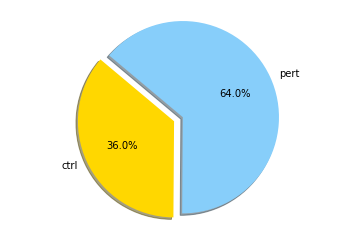

In [0]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'ctrl', 'pert'
sizes = [36, 64]
colors = ['gold','lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Combining Title + Description + source_name + characteristics

In [0]:
# wordnet_lemmatizer = WordNetLemmatizer()

# stop_words = set(stopwords.words('english')) 



# x = df_ctrl['total'].values
# x_proc = []
# pattern_to_find1 = "[^a-zA-Z0-9- ]"
# pattern_to_repl1 = " "
# pattern_to_find2 = "[^a-zA-Z- ]";
# pattern_to_repl2 = ""

# preprocessed_text = []
# total_string_labels = ''

# for sample in x:
#     try:
#         pre_txt = re.sub(pattern_to_find1, pattern_to_repl1, sample)
#         pre_txt = re.sub(pattern_to_find2, pattern_to_repl2, pre_txt).lower()
#         pre_txt = re.sub(' +', ' ',pre_txt)
#         pre_txt = pre_txt.replace("ctrl", "control")
#         pre_txt = pre_txt.replace("contol", "control")
#         pre_txt = pre_txt.replace("non-", "non")
#         pre_txt = pre_txt.replace("-", " ")

#         total_string_labels+=pre_txt
#         pre_proc_ver = ' '.join(wordnet_lemmatizer.lemmatize(w) for w in pre_txt.split() if w not in stop_words and len(w)>1)
#         x_proc.append(' '.join(w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1))
#     #     print(pre_txt.strip())
#         preprocessed_text.extend([w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1])
# #         preprocessed_text.extend(pre_txt.strip().split())
#     except:
#         continue    
        
# # print(preprocessed_text)        
# counts = Counter(preprocessed_text)
# print('Total Distinct Words in the combined text: ' + str(len(counts)))

In [0]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
# nltk.download('averaged_perceptron_tagger')

# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
wordnet_lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 



x = df_ctrl['total'].values
x_proc = []
pattern_to_find1 = "[^a-zA-Z0-9- ]"
pattern_to_repl1 = " "
pattern_to_find2 = "[^a-zA-Z- ]";
pattern_to_repl2 = ""

preprocessed_text = []
total_string_labels = ''

for sample in x:
    try:
        pre_txt = re.sub(pattern_to_find1, pattern_to_repl1, sample)
        pre_txt = re.sub(pattern_to_find2, pattern_to_repl2, pre_txt).lower()
        
        pre_txt = pre_txt.replace("ctrl", "control")
        pre_txt = pre_txt.replace("contol", "control")
        pre_txt = pre_txt.replace("non ", "non")
        pre_txt = pre_txt.replace("non-", "non")
        
        pre_txt = pre_txt.replace("-", " ")
        pre_txt = re.sub(' +', ' ',pre_txt)
        

        total_string_labels+=pre_txt
        pre_proc_ver = ' '.join(wordnet_lemmatizer.lemmatize(token) for token in pre_txt.split() if token not in stop_words and len(token)>1)
        x_proc.append(pre_proc_ver)
    #     print(pre_txt.strip())
        preprocessed_text.extend([w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1])
#         preprocessed_text.extend(pre_txt.strip().split())
    except:
        continue    
        
# print(preprocessed_text)        
counts = Counter(preprocessed_text)
print('Total Distinct Words in the combined text: ' + str(len(counts)))

Total Distinct Words in the combined text: 13725


In [0]:
print(counts)
print(counts['nonebs'])
print(counts['nonuv'])

Counter({'cell': 82666, 'tissue': 44865, 'strain': 30621, 'type': 29933, 'control': 28352, 'date': 27127, 'liver': 26902, 'mouse': 26322, 'male': 23836, 'mg': 23773, 'cd': 22512, 'kg': 22499, 'time': 21860, 'rna': 21602, 'line': 21511, 'rep': 21014, 'gene': 19045, 'expression': 18903, 'age': 18663, 'genotype': 18088, 'treatment': 18009, 'rat': 17635, 'day': 16251, 'vehicle': 15888, 'replicate': 15461, 'sex': 14917, 'dose': 14857, 'data': 14353, 'hybridization': 14178, 'number': 13922, 'wt': 13791, 'sample': 13403, 'drug': 13370, 'primary': 13245, 'dawley': 13097, 'extraction': 13087, 'sprague': 13020, 'cbl': 13017, 'treated': 12829, 'http': 12741, 'nih': 12733, 'detail': 12612, 'complete': 12575, 'dataset': 12552, 'accession': 12549, 'found': 12534, 'matrix': 12489, 'gov': 12446, 'cebs': 12440, 'niehs': 12440, 'heart': 12113, 'compound': 12017, 'gender': 12002, 'route': 11963, 'ig': 11805, 'kidney': 11294, 'hepatocytes': 11234, 'biological': 10755, 'human': 10342, 'wild': 10146, 'oral'

In [0]:
def cnt_in_count(x):
    xx = counts.values()
    cnt = 0
    for i in xx:
        if i >= x:
            cnt+=1
    return cnt
print('Total No of words having count/Freq > 10: '+ str(cnt_in_count(10)))
print('Total No of words having count/Freq > 50: '+ str(cnt_in_count(50)))
print('Total No of words having count/Freq > 100: '+ str(cnt_in_count(100)))
print('Total No of words having count/Freq > 1000: '+ str(cnt_in_count(1000)))
print('Total No of words having count/Freq > 5000: '+ str(cnt_in_count(5000)))
print('Total No of words having count/Freq > 10000: '+ str(cnt_in_count(10000)))
print('Total No of words having count/Freq > 50000: '+ str(cnt_in_count(50000)))


Total No of words having count/Freq > 10: 8946
Total No of words having count/Freq > 50: 3580
Total No of words having count/Freq > 100: 2181
Total No of words having count/Freq > 1000: 260
Total No of words having count/Freq > 5000: 85
Total No of words having count/Freq > 10000: 61
Total No of words having count/Freq > 50000: 1


# ML Models on this Preprocessed Data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x_proc, df_ctrl['ctrl'], test_size=0.2)
nltk.download('punkt')
vectorizer = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)
train_vect = vectorizer.fit_transform(X_train)
test_vect = vectorizer.transform(X_test)
features = vectorizer.get_feature_names()
# print('features used by CountVectorizer: '+ str(features))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
print('Top 50 frequent words')

for t in counts.most_common(50):
    print(t) 

Top 50 frequent words
('cell', 82666)
('tissue', 44865)
('strain', 30621)
('type', 29933)
('control', 28352)
('date', 27127)
('liver', 26902)
('mouse', 26322)
('male', 23836)
('mg', 23773)
('cd', 22512)
('kg', 22499)
('time', 21860)
('rna', 21602)
('line', 21511)
('rep', 21014)
('gene', 19045)
('expression', 18903)
('age', 18663)
('genotype', 18088)
('treatment', 18009)
('rat', 17635)
('day', 16251)
('vehicle', 15888)
('replicate', 15461)
('sex', 14917)
('dose', 14857)
('data', 14353)
('hybridization', 14178)
('number', 13922)
('wt', 13791)
('sample', 13403)
('drug', 13370)
('primary', 13245)
('dawley', 13097)
('extraction', 13087)
('sprague', 13020)
('cbl', 13017)
('treated', 12829)
('http', 12741)
('nih', 12733)
('detail', 12612)
('complete', 12575)
('dataset', 12552)
('accession', 12549)
('found', 12534)
('matrix', 12489)
('gov', 12446)
('cebs', 12440)
('niehs', 12440)


## All Predictive Models at a Single Place (5 fold cross validation)

In [0]:
nltk.download('punkt')
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']


cv = ShuffleSplit(n_splits=5, test_size=0.2)
vect = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)

# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
   
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ValueError: ignored

## Logistic  Model Interpretations

In [0]:
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
# print(df.head(5))
X = df['X']
y = df['Y']

ss = ShuffleSplit(n_splits=10, test_size=0.2)

accs = []
f1s = []
cms = []

vect = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)

nb = LogisticRegression()

for train_index, test_index in ss.split(X):
#     print(train_index)
#     print(test_index)
    
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Oversample
#     X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_vect, y_train)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


anal = dict(zip(vect.get_feature_names(), nb.coef_[0]))
sort_anal = sorted(anal.items(), key=operator.itemgetter(1))

rev_anal = sorted(anal.items(), key=operator.itemgetter(1),reverse =True)
# print(anal)

print('\n\nTop words contributes to CTRL: ')
for key,value in rev_anal[:10]:
    print((key,value))

print('\n\nTop words contributes to PERT: ')
for key,value in sort_anal[:10]:
    print((key,value))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar


Average accuracy across folds: 96.75%

Average F1 score across folds: 95.46%

Average Confusion Matrix across folds: 
 [[9771.6  195.6]
 [ 312.3 5333.5]]


Top words contributes to CTRL: 
('clpp', 4.251540147940994)
('nfshrna', 3.984402569599516)
('dj', 3.936846562939609)
('ctr', 3.672818594721283)
('gska', 3.4180094826301928)
('control', 3.324282196993098)
('nonrecur', 3.2774403991100236)
('wildtype', 3.143168742056121)
('dmso', 3.0938393454683357)
('uspko', 2.89055806507475)


Top words contributes to PERT: 
('compound', -5.743459913234003)
('nonexpressing', -5.701073428635559)
('nhbe', -4.643444667687668)
('xcgd', -4.289878881958684)
('kiki', -4.256413370929942)
('timepoints', -3.1008746828318783)
('bmms', -2.9293565736138043)
('biopsie', -2.908679960910925)
('actinomycin', -2.8894919262056478)
('alcohol', -2.8649482327924805)


## Voting Classifier of 8 Models

In [0]:

nltk.download('punkt')
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']

cv = ShuffleSplit(n_splits=5, test_size=0.2)
vect = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)
model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier(),
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]


# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}
cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    t = 0
    estimators = []
    for model in models:
        
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
#     model = models[8]
#     .fit(X_train_vect, y_train)
#     y_pred = model.predict(X_test_vect)
#     acc = accuracy_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     cm = confusion_matrix(y_test, y_pred)
    
#     print(acc,f1)
#     print(cm)
    
#     results[model.__class__.__name__]['accuracy'].append(acc)
#     results[model.__class__.__name__]['f1_score'].append(f1)
#     results[model.__class__.__name__]['confusion_matrix'].append(cm)

for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of ite

MultinomialNB
------------------------------
        Avg. Accuracy: 75.34%
        Avg. F1 Score: 73.19
        Avg. Confusion Matrix: 
        
[[6507.6 3474.2]
 [ 376.4 5254.8]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 58.39%
        Avg. F1 Score: 62.17
        Avg. Confusion Matrix: 
        
[[3776.6 6205.2]
 [ 292.  5339.2]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 96.80%
        Avg. F1 Score: 95.52
        Avg. Confusion Matrix: 
        
[[9791.2  190.6]
 [ 308.4 5322.8]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 96.58%
        Avg. F1 Score: 95.21
        Avg. Confusion Matrix: 
        
[[9766.   215.8]
 [ 318.4 5312.8]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 97.31%
        Avg. F1 Score: 96.25
        Avg. Confusion Matrix: 
        
[[9792.8  189. ]
 [ 231.6 5399.6]]
        
RandomForestClassifier
------------------------------
  

## Applied Model in the Paper

In [0]:
from sklearn.ensemble import BaggingClassifier
nltk.download('punkt')

df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']

cv = ShuffleSplit(n_splits=10, test_size=0.1)
vect = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)

# Models Used
models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]


# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}
cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
#     print(X_train_vect[100])

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)

for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])

    slashes = '-' * 30

    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
BaggingClassifier
------------------------------
        Avg. Accuracy: 75.76%
        Avg. F1 Score: 73.44
        Avg. Confusion Matrix: 
        
[[3297.  1710.1]
 [ 182.7 2617.2]]
        


In [0]:
# for i in range(0,20):
#     nb = models[0].estimators_[i]
#     print(nb.coef_)
#     anal = dict(zip(vect.get_feature_names(), nb.feature_log_prob_[1]))
#     anall = dict(zip(vect.get_feature_names(), nb.feature_log_prob_[0]))
#     sort_anal = sorted(anal.items(), key=operator.itemgetter(1),reverse=True)

#     rev_anal = sorted(anall.items(), key=operator.itemgetter(1),reverse=True)
#     # print(anal)

#     print('\n\nTop words contributes to CTRL: ')
#     for key,value in sort_anal[:10]:
#         print((key,value))

#     print('\n\nTop words contributes to PERT: ')
#     for key,value in rev_anal[:10]:
#         print((key,value))  
for i in range(0,2):
    nb = models[0].estimators_[i]      
    index = 0
    coef_features_c1_c2 = []

    for feat, c1, c2 in zip(vect.get_feature_names(), nb.feature_count_[0], nb.feature_count_[1]):
        coef_features_c1_c2.append(tuple([nb.coef_[0][index], feat, c1, c2,index]))
        index+=1

    for i in sorted(coef_features_c1_c2, reverse = True)[:25]:
        print(i)
    print("----------------------------------------")

(-3.098520054021563, 'cell', 44213.0, 30570.0, 1308)
(-3.3807759883807904, 'control', 2280.0, 23052.0, 1706)
(-3.7830362431611793, 'type', 11886.0, 15417.0, 9410)
(-3.9316352758488797, 'tissue', 27204.0, 13288.0, 9098)
(-4.103551378874416, 'wt', 1409.0, 11189.0, 9859)
(-4.190124148678477, 'mouse', 12913.0, 10261.0, 5593)
(-4.410421432881961, 'wild', 1020.0, 8232.0, 9822)
(-4.419327732222234, 'strain', 19357.0, 8159.0, 8627)
(-4.479561805312752, 'line', 11588.0, 7682.0, 4849)
(-4.513853905714351, 'genotype', 9101.0, 7423.0, 3309)
(-4.518038294623286, 'rep', 11317.0, 7392.0, 7510)
(-4.550620735551776, 'expression', 10012.0, 7155.0, 2843)
(-4.552859124846757, 'age', 9791.0, 7139.0, 204)
(-4.557210314250904, 'gene', 10137.0, 7108.0, 3286)
(-4.651086721442059, 'treatment', 9576.0, 6471.0, 9275)
(-4.7340049025517, 'replicate', 8033.0, 5956.0, 7524)
(-4.781268617766253, 'day', 9077.0, 5681.0, 1944)
(-4.838302808003558, 'data', 7606.0, 5366.0, 1936)
(-4.841662273649137, 'male', 16133.0, 5348.0

# Rough

In [0]:
vect = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)


# X_train, X_test, y_train, y_test = train_test_split(x_proc, df_ctrl['ctrl'].values, test_size=0.2)
tot_vect = vect.fit_transform(x_proc)
features = vect.get_feature_names()
coef_features = []
index =0
for c1 in vect.get_feature_names():
    coef_features.append((c1, index))
    index+=1

    
for i in sorted(coef_features):
    print(i,counts[i[0]])
   
# df = pd.DataFrame({'GSM':df_ctrl.sample_id,'pert':df_ctrl.pert,'ctrl count':})


('aa', 0) 546
('aaa', 1) 56
('aac', 2) 32
('aad', 3) 39
('aaf', 4) 25
('aag', 5) 27
('aale', 6) 33
('aam', 7) 9
('aar', 8) 28
('aav', 9) 66
('aavtfeb', 10) 16
('ab', 11) 260
('abamectin', 12) 27
('abbreviated', 13) 15
('abbreviation', 14) 20
('abc', 15) 16
('abca', 16) 29
('abcb', 17) 45
('abcg', 18) 12
('abdomen', 19) 9
('abdominal', 20) 96
('aberrant', 21) 40
('abh', 22) 9
('abi', 23) 29
('abl', 24) 184
('ablation', 25) 20
('abnormal', 26) 79
('abnormality', 27) 38
('absence', 28) 125
('absent', 29) 84
('absolute', 30) 22
('absolutely', 31) 21
('absorbance', 32) 20
('absorption', 33) 18
('abstract', 34) 8
('abundance', 35) 13
('abuse', 36) 373
('aby', 37) 12
('ac', 38) 47
('acad', 39) 21
('acarbose', 40) 27
('acat', 41) 8
('acc', 42) 55
('accelerated', 43) 77
('accepted', 44) 10
('access', 45) 155
('accession', 46) 12549
('accident', 47) 10
('acclimate', 48) 16
('acclimation', 49) 10
('accompanying', 50) 26
('accordance', 51) 57
('according', 52) 769
('account', 53) 28
('accp', 54) 1

In [0]:
ctrl_pres = []

for smpl in x_proc[-10000:]:
    if "control" in smpl.split():
        ctrl_pres.append(1)
    else:
        ctrl_pres.append(0)
cnt = 0

for c1,c2,c3,c4 in zip(df_ctrl.pert[-10000:],ctrl_pres[-10000:],df_ctrl.sample_id[-10000:],x_proc[-10000:]):
    
    if c1 == 1 and c2 == 1:
        print(c3,c4)
        cnt+=1

print(cnt)


# for c1,c2,c3,c4 in zip(df_ctrl.pert,ctrl_pres,df_ctrl.sample_id,x_proc):
    
#     if c1 == 1 and c2 == 1:
#         print(c3,c4)
#         cnt+=1

GSM544750 otx cko ex gene expression data control retina tissue retina genotype otx flox flox crx cre time retina otx cko mouse
GSM544751 otx cko ex gene expression data control retina tissue retina genotype otx flox flox crx cre time retina otx cko mouse
GSM544752 otx cko ex gene expression data control retina tissue retina genotype otx flox flox crx cre time retina otx cko mouse
GSM439954 control tibialis anterior muscle muscle specific pgamma knockout mouse gene expression data contralateral control tibialis anterior muscle muscle specific pgamma knockout mouse tissue tibialis anterior muscle genotype cbl age week old mouse type pgamma knockout mouse control tibialis anterior muscle muscle specific pgamma knockout mouse
GSM439958 control tibialis anterior muscle muscle specific pgamma knockout mouse gene expression data contralateral control tibialis anterior muscle muscle specific pgamma knockout mouse tissue tibialis anterior muscle genotype cbl age week old mouse type pgamma knoc

# ON MANUAL TEST DATASET - 10000 samples

In [0]:
# df1 = pd.read_csv('drug.csv')
# print('columns:',end=' ')
# print(df1.columns.values)
# print('No of Data Points: ' + str(len(df1)))

# df2 = pd.read_csv('disease.csv')
# print('columns:',end=' ')
# print(df2.columns.values)
# print('No of Data Points: ' + str(len(df2)))

# df3 = pd.read_csv('gene.csv')
# print('columns:',end=' ')
# print(df3.columns.values)
# print('No of Data Points: ' + str(len(df3)))

# df_test = pd.concat([df1,df2,df3])
# print('columns:',end=' ')
# print(df_test.columns.values)
# print('No of Data Points: ' + str(len(df_test)))
# # df_ctrl = df_ctrl.replace(np.nan, '', regex=True)

# # df_ctrl['total'] = df_ctrl['title'].str.cat(' '+ df_ctrl['description'].str.cat(' '+ df_ctrl['characteristics_ch1'].str.cat(' '+ df_ctrl['source_name_ch1'])))
# # df_ctrl['total']  = df_ctrl['total'].replace('\s+', ' ', regex=True)
# # df_ctrl.to_csv('creeds_control_data.csv',index=False)

# df_test = df_test.replace(np.nan, '', regex=True)
# df_test['total'] = df_test['title'].str.cat(' '+ df_test['description'].str.cat(' '+ df_test['characteristics_ch1'].str.cat(' '+ df_test['source_name_ch1'])))
# df_test['total']  = df_test['total'].replace('\s+', ' ', regex=True)
# df_test.to_csv('test_data.csv',index=False)
df1 = pd.read_csv('drug.csv')
df1 = df1.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df1.columns.values)
print('No of Data Points: ' + str(len(df1)))

df2 = pd.read_csv('disease.csv')
df2 = df2.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df2.columns.values)
print('No of Data Points: ' + str(len(df2)))

df3 = pd.read_csv('gene.csv')
df3 = df3.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df3.columns.values)
print('No of Data Points: ' + str(len(df3)))

df_test = pd.concat([df1,df2,df3])
print('columns:',end=' ')
print(df_test.columns.values)
print('No of Data Points: ' + str(len(df_test)))
# df_ctrl = df_ctrl.replace(np.nan, '', regex=True)

# df_ctrl['total'] = df_ctrl['title'].str.cat(' '+ df_ctrl['description'].str.cat(' '+ df_ctrl['characteristics_ch1'].str.cat(' '+ df_ctrl['source_name_ch1'])))
# df_ctrl['total']  = df_ctrl['total'].replace('\s+', ' ', regex=True)
# df_ctrl.to_csv('creeds_control_data.csv',index=False)

df_test = df_test.replace(np.nan, '', regex=True)
df_test['total'] = df_test['title'].str.cat(' '+ df_test['description'].str.cat(' '+ df_test['characteristics_ch1'].str.cat(' '+ df_test['source_name_ch1'])))
df_test['total']  = df_test['total'].replace('\s+', ' ', regex=True)
df_test.to_csv('test_data.csv',index=False)

columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 3666
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 4291
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 3281
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 11238


In [0]:
df_test["Ctrl"] = df_test["Ctrl"].fillna(0.0).astype(int)


## Models on 10000 *samples*

In [0]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
# nltk.download('averaged_perceptron_tagger')

# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
wordnet_lemm = WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 


x = df_test['total'].values
test_proc = []
pattern_to_find1 = "[^a-zA-Z0-9- ]"
pattern_to_repl1 = " "
pattern_to_find2 = "[^a-zA-Z- ]";
pattern_to_repl2 = ""
test_preprocessed_text = []
total_string_labels = ''

for sample in x:
    try:
        pre_txt = re.sub(pattern_to_find1, pattern_to_repl1, sample)
        pre_txt = re.sub(pattern_to_find2, pattern_to_repl2, pre_txt).lower()
       
        pre_txt = pre_txt.replace("ctrl", "control")
        pre_txt = pre_txt.replace("contol", "control")
        pre_txt = pre_txt.replace("non ", "non")
        pre_txt = pre_txt.replace("non-", "non")
        
        pre_txt = pre_txt.replace("-", " ")
        pre_txt = re.sub(' +', ' ',pre_txt)
        
       
        total_string_labels+=pre_txt
        pre_proc_ver = ' '.join(wordnet_lemm.lemmatize(w) for w in pre_txt.split() if w not in stop_words and len(w)>1)
        
        test_proc.append(pre_proc_ver)
        
        test_preprocessed_text.extend([w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1])
#         preprocessed_text.extend(pre_txt.strip().split())
    except:
        continue    
# print(preprocessed_text)        
counts1 = Counter(test_preprocessed_text)
print('Total Distinct Words in the combined text: ' + str(len(counts1)))
#1039 - 838 present

Total Distinct Words in the combined text: 2177


In [0]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
x1 = counts.keys()
x2 = counts1.keys()
print(len(intersection(x1, x2)))
x2_x1 = list(set(x2) - set(x1))
for i in x2_x1:
    print(i)

In [0]:
nltk.download('punkt')
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']
X_t = test_proc
y_t = df_test['Ctrl'].values

cv = ShuffleSplit(n_splits=5, test_size=0.2)
vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        y_t_pred = model.predict(X_t_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of ite

MultinomialNB
------------------------------
        Avg. Accuracy: 75.45%
        Avg. F1 Score: 73.17
        Avg. Confusion Matrix: 
        
[[6555.  3437.6]
 [ 395.  5225.4]]
        Avg. Test Accuracy: 63.78%
        Avg. Test F1 Score: 66.75
        Avg. Test Confusion Matrix: 
        
[[3081.2 3844.8]
 [ 226.  4086. ]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 58.63%
        Avg. F1 Score: 62.19
        Avg. Confusion Matrix: 
        
[[3843.8 6148.8]
 [ 309.8 5310.6]]
        Avg. Test Accuracy: 46.65%
        Avg. Test F1 Score: 58.95
        Avg. Test Confusion Matrix: 
        
[[ 937.8 5988.2]
 [   7.2 4304.8]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 96.55%
        Avg. F1 Score: 95.14
        Avg. Confusion Matrix: 
        
[[9798.8  193.8]
 [ 344.8 5275.6]]
        Avg. Test Accuracy: 88.42%
        Avg. Test F1 Score: 84.52
        Avg. Test Confusion Matrix: 
        
[[6383.4  542.6]
 [ 758.

In [0]:
from sklearn.ensemble import BaggingClassifier

nltk.download('punkt')
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']
X_t = test_proc
y_t = df_test['Ctrl'].values
cv = ShuffleSplit(n_splits=10, test_size=0.1)
vect = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)

# Models Used
models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        y_t_pred = model.predict(X_t_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
BaggingClassifier
------------------------------
        Avg. Accuracy: 75.87%
        Avg. F1 Score: 73.59
        Avg. Confusion Matrix: 
        
[[3298.3 1693.1]
 [ 190.9 2624.7]]
        Avg. Test Accuracy: 63.85%
        Avg. Test F1 Score: 66.62
        Avg. Test Confusion Matrix: 
        
[[3121.7 3804.3]
 [ 258.2 4053.8]]
        


In [0]:
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']
X_t = test_proc
y_t = df_test['Ctrl'].values

cv = ShuffleSplit(n_splits=5, test_size=0.2)
vect = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)
model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]


# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        y_t_pred = model.predict(X_t_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of ite

VotingClassifier
------------------------------
        Avg. Accuracy: 97.14%
        Avg. F1 Score: 95.98
        Avg. Confusion Matrix: 
        
[[9826.4  203.6]
 [ 243.4 5339.6]]
        Avg. Test Accuracy: 88.42%
        Avg. Test F1 Score: 84.67
        Avg. Test Confusion Matrix: 
        
[[6339.2  586.8]
 [ 714.2 3597.8]]
        


##All Models on 9000 samples train and remaining test

In [0]:
import random
nltk.download('punkt')


vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:88000], X[88000:]
    y_train, y_test = y[:88000], y[88000:]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MultinomialNB
------------------------------
        Avg. Accuracy: 82.08%
        Avg. F1 Score: 80.77
        Avg. Confusion Matrix: 
        
[[577.2 220.4]
 [ 12.4 489. ]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 72.29%
        Avg. F1 Score: 73.40
        Avg. Confusion Matrix: 
        
[[442.2 355.4]
 [  4.6 496.8]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 98.38%
        Avg. F1 Score: 97.91
        Avg. Confusion Matrix: 
        
[[787.6  10. ]
 [ 11.  490.4]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 98.23%
        Avg. F1 Score: 97.71
        Avg. Confusion Matrix: 
        
[[786.4  11.2]
 [ 11.8 489.6]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 98.83%
        Avg. F1 Score: 98.48
        Avg. Confusion Matrix: 
        
[[790.4   7.2]
 [  8.  493.4]]
        
RandomForestClassifier
------------------------------
        Avg. Accuracy:

In [0]:
print(len(pred))
print(pred[2])
df_test['Logistic'] = pred[2]
df_test.to_csv('predicted_data.csv',index=False)

8
[1 0 1 ... 0 0 0]


In [0]:
df_wrong = df_test[df_test['Logistic'] != df_test['Ctrl']]
print(len(df_wrong))

df_wrong.to_csv('wrongly_predicted_data.csv',index=False)

194


### Bagging - Applied in the paper

In [0]:
from sklearn.ensemble import BaggingClassifier
import random

nltk.download('punkt')

models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]

vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:88000], X[88000:]
    y_train, y_test = y[:88000], y[88000:]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
11238 11238
78061
89299
89299
11238 11238
78061
89299
89299
11238 11238
78061
89299
89299
11238 11238
78061
89299
89299
11238 11238
78061
89299
89299
BaggingClassifier
------------------------------
        Avg. Accuracy: 80.34%
        Avg. F1 Score: 79.06
        Avg. Confusion Matrix: 
        
[[561.4 241.8]
 [ 13.6 482.2]]
        


### Voting Classifier

In [0]:

model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]

vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:88000], X[88000:]
    y_train, y_test = y[:88000], y[88000:]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier
------------------------------
        Avg. Accuracy: 98.52%
        Avg. F1 Score: 97.99
        Avg. Confusion Matrix: 
        
[[811.4  11. ]
 [  8.2 468.4]]
        


In [0]:
# df_test = df_ctrl[df_ctrl['total'].str.contains("ef wt")]
# print(len(df_test))
# print(len(df_test[df_test['ctrl']==1]))


df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
df_test = df[df['X'].str.contains("nhbe")]
print(len(df_test))
print(len(df_test[df_test['Y']==1]))

60
3


## All Models on 70000,10000,9300 train-valid-test split







In [0]:
import random
nltk.download('punkt')

cv = ShuffleSplit(n_splits=5, test_size=10000)
vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

test_data = test_proc
test_labels = df_test['Ctrl'].values.tolist()


samp_proc = x_proc.copy()
print(len(samp_proc))
samp_proc.extend(test_data)
labels = df_ctrl['ctrl'].values.tolist()
labels.extend(test_labels)
print(len(labels))

mapIndexPosition = list(zip(samp_proc,labels))
random.shuffle(mapIndexPosition)
samp_proc, labels = zip(*mapIndexPosition)

X, X_t  = samp_proc[:80000], samp_proc[80000:]
y, y_t = labels[:80000], labels[80000:]


nltk.download('punkt')
df = pd.DataFrame({'X':X,'Y':y})
X = df['X']
y = df['Y']

pred = []

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    
    
    print(len(X_train),len(X_test),len(X_t))
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        y_t_pred = model.predict(X_t_vect)
        pred.append(y_t_pred)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
78061
89299
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MultinomialNB
------------------------------
        Avg. Accuracy: 77.40%
        Avg. F1 Score: 75.16
        Avg. Confusion Matrix: 
        
[[4319.6 2018.2]
 [ 242.2 3420. ]]
        Avg. Test Accuracy: 77.73%
        Avg. Test F1 Score: 75.55
        Avg. Test Confusion Matrix: 
        
[[4027.8 1868.2]
 [ 203.  3200. ]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 61.88%
        Avg. F1 Score: 64.54
        Avg. Confusion Matrix: 
        
[[2718.6 3619.2]
 [ 192.6 3469.6]]
        Avg. Test Accuracy: 61.97%
        Avg. Test F1 Score: 64.74
        Avg. Test Confusion Matrix: 
        
[[2515.6 3380.4]
 [ 156.4 3246.6]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 96.79%
        Avg. F1 Score: 95.56
        Avg. Confusion Matrix: 
        
[[6219.4  118.4]
 [ 202.6 3459.6]]
        Avg. Test Accuracy: 96.85%
        Avg. Test F1 Score: 95.64
        Avg. Test Confusion Matrix: 
        
[[5786.4  109.6]
 [ 183.

In [0]:
print(len(pred))
print(pred[2])
df_test['Logistic'] = pred[2]
df_test.to_csv('predicted_data.csv',index=False)

In [0]:
df_wrong = df_test[df_test['Logistic'] != df_test['Ctrl']]
print(len(df_wrong))

df_wrong.to_csv('wrongly_predicted_data.csv',index=False)

194


### Bagging - Applied in the paper

In [0]:
from sklearn.ensemble import BaggingClassifier
import random

nltk.download('punkt')

models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]

import random
nltk.download('punkt')

cv = ShuffleSplit(n_splits=5, test_size=10000)
vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

test_data = test_proc
test_labels = df_test['Ctrl'].values.tolist()


samp_proc = x_proc.copy()
print(len(samp_proc))
samp_proc.extend(test_data)
labels = df_ctrl['ctrl'].values.tolist()
labels.extend(test_labels)
print(len(labels))

mapIndexPosition = list(zip(samp_proc,labels))
random.shuffle(mapIndexPosition)
samp_proc, labels = zip(*mapIndexPosition)

X, X_t  = samp_proc[:80000], samp_proc[80000:]
y, y_t = labels[:80000], labels[80000:]


nltk.download('punkt')
df = pd.DataFrame({'X':X,'Y':y})
X = df['X']
y = df['Y']

pred = []

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    
    
    print(len(X_train),len(X_test),len(X_t))
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        y_t_pred = model.predict(X_t_vect)
        pred.append(y_t_pred)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
78061
89299
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
70000 10000 9299
70000 10000 9299
70000 10000 9299
70000 10000 9299
70000 10000 9299
BaggingClassifier
------------------------------
        Avg. Accuracy: 77.09%
        Avg. F1 Score: 74.44
        Avg. Confusion Matrix: 
        
[[4371.6 2039.6]
 [ 251.6 3337.2]]
        Avg. Test Accuracy: 77.72%
        Avg. Test F1 Score: 75.38
        Avg. Test Confusion Matrix: 
        
[[4054.  1848. ]
 [ 224.2 3172.8]]
        


### Voting Classifier

In [0]:
import random
nltk.download('punkt')

model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]

vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

cv = ShuffleSplit(n_splits=5, test_size=10000)
vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

test_data = test_proc
test_labels = df_test['Ctrl'].values.tolist()


samp_proc = x_proc.copy()
print(len(samp_proc))
samp_proc.extend(test_data)
labels = df_ctrl['ctrl'].values.tolist()
labels.extend(test_labels)
print(len(labels))

mapIndexPosition = list(zip(samp_proc,labels))
random.shuffle(mapIndexPosition)
samp_proc, labels = zip(*mapIndexPosition)

X, X_t  = samp_proc[:80000], samp_proc[80000:]
y, y_t = labels[:80000], labels[80000:]


nltk.download('punkt')
df = pd.DataFrame({'X':X,'Y':y})
X = df['X']
y = df['Y']

pred = []

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    
    
    print(len(X_train),len(X_test),len(X_t))
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        y_t_pred = model.predict(X_t_vect)
        pred.append(y_t_pred)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
78061
89299
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier
------------------------------
        Avg. Accuracy: 96.07%
        Avg. F1 Score: 94.45
        Avg. Confusion Matrix: 
        
[[6263.6  126.4]
 [ 266.8 3343.2]]
        Avg. Test Accuracy: 95.84%
        Avg. Test F1 Score: 94.19
        Avg. Test Confusion Matrix: 
        
[[5773.2  142.8]
 [ 244.2 3138.8]]
        


In [0]:
# df_test = df_ctrl[df_ctrl['total'].str.contains("ef wt")]
# print(len(df_test))
# print(len(df_test[df_test['ctrl']==1]))


df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
df_test = df[df['X'].str.contains("nhbe")]
print(len(df_test))
print(len(df_test[df_test['Y']==1]))

60
3


## All Models on 78000,10000,5000(only manual data present in test set) train-valid-test split







In [0]:
df1 = pd.read_csv('drug - drug.csv')
df1 = df1.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df1.columns.values)
print('No of Data Points: ' + str(len(df1)))

df2 = pd.read_csv('disease - disease.csv')
df2 = df2.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df2.columns.values)
print('No of Data Points: ' + str(len(df2)))

df3 = pd.read_csv('gene - gene.csv')
df3 = df3.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df3.columns.values)
print('No of Data Points: ' + str(len(df3)))

df_test = pd.concat([df1,df2,df3])
print('columns:',end=' ')
print(df_test.columns.values)
print('No of Data Points: ' + str(len(df_test)))
# df_ctrl = df_ctrl.replace(np.nan, '', regex=True)

# df_ctrl['total'] = df_ctrl['title'].str.cat(' '+ df_ctrl['description'].str.cat(' '+ df_ctrl['characteristics_ch1'].str.cat(' '+ df_ctrl['source_name_ch1'])))
# df_ctrl['total']  = df_ctrl['total'].replace('\s+', ' ', regex=True)
# df_ctrl.to_csv('creeds_control_data.csv',index=False)

df_test = df_test.replace(np.nan, '', regex=True)
df_test['total'] = df_test['title'].str.cat(' '+ df_test['description'].str.cat(' '+ df_test['characteristics_ch1'].str.cat(' '+ df_test['source_name_ch1'])))
df_test['total']  = df_test['total'].replace('\s+', ' ', regex=True)
df_test.to_csv('test_data.csv',index=False)

columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 5308
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 5195
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert' 'Unnamed: 8' 'Unnamed: 9']
No of Data Points: 4660
columns: ['Ctrl' 'Pert' 'Unnamed: 8' 'Unnamed: 9' 'characteristics_ch1'
 'description' 'gse_id' 'sample_id' 'source_name_ch1' 'title']
No of Data Points: 15163


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [0]:
df_test["Ctrl"] = df_test["Ctrl"].fillna(0.0).astype(int)


In [0]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
# nltk.download('averaged_perceptron_tagger')

# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
wordnet_lemm = WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 


x = df_test['total'].values
test_proc = []
pattern_to_find1 = "[^a-zA-Z0-9- ]"
pattern_to_repl1 = " "
pattern_to_find2 = "[^a-zA-Z- ]";
pattern_to_repl2 = ""
test_preprocessed_text = []
total_string_labels = ''

for sample in x:
    try:
        pre_txt = re.sub(pattern_to_find1, pattern_to_repl1, sample)
        pre_txt = re.sub(pattern_to_find2, pattern_to_repl2, pre_txt).lower()
       
        pre_txt = pre_txt.replace("ctrl", "control")
        pre_txt = pre_txt.replace("contol", "control")
        pre_txt = pre_txt.replace("non ", "non")
        pre_txt = pre_txt.replace("non-", "non")
        
        pre_txt = pre_txt.replace("-", " ")
        pre_txt = re.sub(' +', ' ',pre_txt)
        
       
        total_string_labels+=pre_txt
        pre_proc_ver = ' '.join(wordnet_lemm.lemmatize(w) for w in pre_txt.split() if w not in stop_words and len(w)>1)
        
        test_proc.append(pre_proc_ver)
        
        test_preprocessed_text.extend([w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1])
#         preprocessed_text.extend(pre_txt.strip().split())
    except:
        continue    
# print(preprocessed_text)        
counts = Counter(test_preprocessed_text)
print('Total Distinct Words in the combined text: ' + str(len(counts)))

Total Distinct Words in the combined text: 2413


In [0]:
import random
nltk.download('punkt')


vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:-5000], X[-5000:]
    y_train, y_test = y[:-5000], y[-5000:]
    
    mapIndexPosition = list(zip(X_train, y_train))
    random.shuffle(mapIndexPosition)
    X_train, y_train = zip(*mapIndexPosition)
    
    
    mapIndexPosition = list(zip(X_test, y_test))
    random.shuffle(mapIndexPosition)
    X_test, y_test = zip(*mapIndexPosition)
    
    
    print(len(X_train),len(X_test))

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MultinomialNB
------------------------------
        Avg. Accuracy: 80.60%
        Avg. F1 Score: 79.27
        Avg. Confusion Matrix: 
        
[[2175.8  906.2]
 [  63.6 1854.4]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 69.32%
        Avg. F1 Score: 71.17
        Avg. Confusion Matrix: 
        
[[1572.2 1509.8]
 [  24.2 1893.8]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 98.25%
        Avg. F1 Score: 97.70
        Avg. Confusion Matrix: 
        
[[3048.8   33.2]
 [  54.4 1863.6]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 97.94%
        Avg. F1 Score: 97.29
        Avg. Confusion Matrix: 
        
[[3046.8   35.2]
 [  68.  1850. ]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 98.68%
        Avg. F1 Score: 98.28
        Avg. Confusion Matrix: 
        
[[3051.2   30.8]
 [  35.  1883. ]]
        
RandomForestClassifier
------------------------------
  

In [0]:
print(len(pred))
print(pred[2])
df_test['Logistic'] = pred[2]
df_test.to_csv('predicted_data.csv',index=False)

0


IndexError: ignored

In [0]:
df_wrong = df_test[df_test['Logistic'] != df_test['Ctrl']]
print(len(df_wrong))

df_wrong.to_csv('wrongly_predicted_data.csv',index=False)

KeyError: ignored

### Bagging - Applied in the paper

In [0]:
from sklearn.ensemble import BaggingClassifier
import random

nltk.download('punkt')

models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]

vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:-5000], X[-5000:]
    y_train, y_test = y[:-5000], y[-5000:]
    
    mapIndexPosition = list(zip(X_train, y_train))
    random.shuffle(mapIndexPosition)
    X_train, y_train = zip(*mapIndexPosition)
    
    
    mapIndexPosition = list(zip(X_test, y_test))
    random.shuffle(mapIndexPosition)
    X_test, y_test = zip(*mapIndexPosition)
    
    
    print(len(X_train),len(X_test))

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
15163 15163
78061
93224
93224
88224 5000
15163 15163
78061
93224
93224
88224 5000
15163 15163
78061
93224
93224
88224 5000
15163 15163
78061
93224
93224
88224 5000
15163 15163
78061
93224
93224
88224 5000
BaggingClassifier
------------------------------
        Avg. Accuracy: 81.16%
        Avg. F1 Score: 79.70
        Avg. Confusion Matrix: 
        
[[2208.2  874.2]
 [  68.  1849.6]]
        


### Voting Classifier

In [0]:

model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]

vect = CountVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:-5000], X[-5000:]
    y_train, y_test = y[:-5000], y[-5000:]
    
    mapIndexPosition = list(zip(X_train, y_train))
    random.shuffle(mapIndexPosition)
    X_train, y_train = zip(*mapIndexPosition)
    
    
    mapIndexPosition = list(zip(X_test, y_test))
    random.shuffle(mapIndexPosition)
    X_test, y_test = zip(*mapIndexPosition)
    
    
    print(len(X_train),len(X_test))

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier
------------------------------
        Avg. Accuracy: 98.48%
        Avg. F1 Score: 98.00
        Avg. Confusion Matrix: 
        
[[3066.    31.2]
 [  44.8 1858. ]]
        


In [0]:
# df_test = df_ctrl[df_ctrl['total'].str.contains("ef wt")]
# print(len(df_test))
# print(len(df_test[df_test['ctrl']==1]))


df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
df_test = df[df['X'].str.contains("nhbe")]
print(len(df_test))
print(len(df_test[df_test['Y']==1]))

60
3


# Deep neural nets

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

test_data = test_proc
test_labels = df_test['Ctrl'].values.tolist()

mapIndexPosition = list(zip(test_data, test_labels))
random.shuffle(mapIndexPosition)
test_data, test_labels = zip(*mapIndexPosition)

print(len(test_data),len(test_labels))
samp_proc = x_proc.copy()
print(len(samp_proc))
samp_proc.extend(test_data)
labels = df_ctrl['ctrl'].values.tolist()
labels.extend(test_labels)
print(len(labels))
print(len(samp_proc))

maxlen = 500
training_samples = 70000
validation_samples = 10000
test_samples = 8299
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_proc)
sequences = tokenizer.texts_to_sequences(samp_proc)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

print(len(x_train),len(x_val),len(x_test))

15163 15163
78061
93224
93224
Found 13755 unique tokens.
Shape of data tensor: (93224, 500)
Shape of label tensor: (93224,)
70000 10000 13224


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, 200, input_length=maxlen))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

W0705 06:29:15.663331 140379373967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 06:29:15.708299 140379373967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 06:29:15.715417 140379373967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 06:29:15.822318 140379373967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0705 06:29:15.846465 140379373967232 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 200)          2000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51200512  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total para

W0705 06:29:16.156876 140379373967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 70000 samples, validate on 10000 samples
Epoch 1/10
70000/70000 [==============================] - 145s 2ms/step - loss: 0.2387 - acc: 0.9173 - val_loss: 0.1294 - val_acc: 0.9523
Epoch 2/10
70000/70000 [==============================] - 142s 2ms/step - loss: 0.1236 - acc: 0.9582 - val_loss: 0.1276 - val_acc: 0.9554
Epoch 3/10
70000/70000 [==============================] - 141s 2ms/step - loss: 0.1177 - acc: 0.9647 - val_loss: 0.1118 - val_acc: 0.9669
Epoch 4/10
70000/70000 [==============================] - 141s 2ms/step - loss: 0.1252 - acc: 0.9635 - val_loss: 0.1746 - val_acc: 0.9463
Epoch 5/10
70000/70000 [==============================] - 141s 2ms/step - loss: 0.1462 - acc: 0.9625 - val_loss: 0.1096 - val_acc: 0.9681
Epoch 6/10
70000/70000 [==============================] - 141s 2ms/step - loss: 0.2075 - acc: 0.9589 - val_loss: 0.3964 - val_acc: 0.9574
Epoch 7/10
70000/70000 [==============================] - 140s 2ms/step - loss: 0.2501 - acc: 0.9589 - val_loss: 0.2259 - 

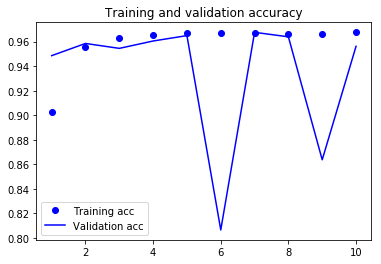

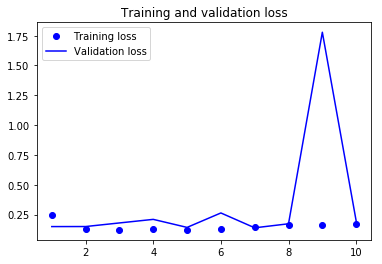

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
sequences = tokenizer.texts_to_sequences(test_proc)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(df_test['Ctrl'].values)
acc = model.evaluate(x_test, y_test)
print(acc)

2159/2159 [==============================] - 0s 116us/step
[0.8987695282076321, 0.8221398795738768]


# Simple RNN

In [0]:
from keras.layers import Dense,SimpleRNN
model = Sequential()
model.add(Embedding(max_words, 200, input_length=maxlen))
model.add(SimpleRNN(200))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_data=(x_val, y_val))

Train on 50000 samples, validate on 15000 samples
Epoch 1/10
50000/50000 [==============================] - 119s 2ms/step - loss: 0.3687 - acc: 0.8275 - val_loss: 0.5766 - val_acc: 0.6999
Epoch 2/10
50000/50000 [==============================] - 118s 2ms/step - loss: 0.3016 - acc: 0.8752 - val_loss: 0.1984 - val_acc: 0.9355
Epoch 3/10
50000/50000 [==============================] - 117s 2ms/step - loss: 0.1858 - acc: 0.9384 - val_loss: 0.1886 - val_acc: 0.9391
Epoch 4/10
50000/50000 [==============================] - 116s 2ms/step - loss: 0.1586 - acc: 0.9483 - val_loss: 0.1642 - val_acc: 0.9488
Epoch 5/10
50000/50000 [==============================] - 115s 2ms/step - loss: 0.1294 - acc: 0.9567 - val_loss: 0.1445 - val_acc: 0.9510
Epoch 6/10
50000/50000 [==============================] - 113s 2ms/step - loss: 0.1025 - acc: 0.9648 - val_loss: 0.1366 - val_acc: 0.9520
Epoch 7/10
50000/50000 [==============================] - 113s 2ms/step - loss: 0.1113 - acc: 0.9599 - val_loss: 0.1363 - 

In [0]:
sequences = tokenizer.texts_to_sequences(test_proc)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(df_test['Ctrl'].values)
acc = model.evaluate(x_test, y_test)
print(acc)

2159/2159 [==============================] - 14s 6ms/step
[0.3852722476244718, 0.8906901343490526]


# LSTM

In [0]:
from keras.layers import Dense,SimpleRNN,LSTM
model = Sequential()

model.add(Embedding(max_words, 200, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_data=(x_val, y_val))

Train on 50000 samples, validate on 15000 samples
Epoch 1/10
50000/50000 [==============================] - 299s 6ms/step - loss: 0.2415 - acc: 0.9078 - val_loss: 0.1432 - val_acc: 0.9544
Epoch 2/10
50000/50000 [==============================] - 296s 6ms/step - loss: 0.1136 - acc: 0.9608 - val_loss: 0.1145 - val_acc: 0.9624
Epoch 3/10
50000/50000 [==============================] - 295s 6ms/step - loss: 0.0831 - acc: 0.9689 - val_loss: 0.0961 - val_acc: 0.9670
Epoch 4/10
50000/50000 [==============================] - 296s 6ms/step - loss: 0.0689 - acc: 0.9727 - val_loss: 0.0856 - val_acc: 0.9683
Epoch 5/10
50000/50000 [==============================] - 295s 6ms/step - loss: 0.0589 - acc: 0.9756 - val_loss: 0.0861 - val_acc: 0.9690
Epoch 6/10
50000/50000 [==============================] - 294s 6ms/step - loss: 0.0663 - acc: 0.9733 - val_loss: 0.0894 - val_acc: 0.9676
Epoch 7/10
50000/50000 [==============================] - 294s 6ms/step - loss: 0.0506 - acc: 0.9780 - val_loss: 0.0803 - 

In [0]:
sequences = tokenizer.texts_to_sequences(test_proc)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(df_test['Ctrl'].values)
acc = model.evaluate(x_test, y_test)
print(acc)

2159/2159 [==============================] - 17s 8ms/step
[0.5694250220099323, 0.9073645206113942]


# GRU

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,GRU
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, 200, input_length=maxlen))

model.add(GRU(32,
dropout=0.1,
recurrent_dropout=0.5,
return_sequences=False,
input_shape=(None, x_train.shape[-1])))
# model.add(GRU(64, activation='relu',
# dropout=0.1,
# recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_data=(x_val, y_val))

Train on 50000 samples, validate on 15000 samples
Epoch 1/10
50000/50000 [==============================] - 296s 6ms/step - loss: 0.4864 - acc: 0.7932 - val_loss: 0.3732 - val_acc: 0.8585
Epoch 2/10
50000/50000 [==============================] - 290s 6ms/step - loss: 0.3579 - acc: 0.8181 - val_loss: 0.3739 - val_acc: 0.8347
Epoch 3/10
50000/50000 [==============================] - 287s 6ms/step - loss: 0.3394 - acc: 0.7959 - val_loss: 0.3541 - val_acc: 0.8229
Epoch 4/10
50000/50000 [==============================] - 290s 6ms/step - loss: 0.2944 - acc: 0.7923 - val_loss: 0.3262 - val_acc: 0.7939
Epoch 5/10
50000/50000 [==============================] - 288s 6ms/step - loss: 0.2715 - acc: 0.7276 - val_loss: 0.2907 - val_acc: 0.7911
Epoch 6/10
50000/50000 [==============================] - 286s 6ms/step - loss: 0.2577 - acc: 0.7477 - val_loss: 0.2708 - val_acc: 0.7883
Epoch 7/10
50000/50000 [==============================] - 289s 6ms/step - loss: 0.2469 - acc: 0.7020 - val_loss: 0.2622 - 

In [0]:
sequences = tokenizer.texts_to_sequences(test_proc)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(df_test['Ctrl'].values)
acc = model.evaluate(x_test, y_test)
print(acc)

2159/2159 [==============================] - 17s 8ms/step
[0.6521201738865114, 0.7860120426399281]


# Text CNN

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,GRU,MaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, 200, input_length=maxlen))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_data=(x_val, y_val))


W0705 06:59:45.890533 140379373967232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 200)          2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 256)          153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 166, 256)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 2,170,369
Trainable params: 2,170,369
Non-trainable params: 0
_________________________________________________________________


In [0]:
acc = model.evaluate(x_test, y_test)
print(acc)

13224/13224 [==============================] - 3s 209us/step
[0.0477348317744075, 0.9826830006049607]


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,GRU,MaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, 200, input_length=maxlen))
model.add(layers.Conv1D(256, 2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_data=(x_val, y_val))








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 200)          2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 499, 256)          102656    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 249, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 247, 128)          98432     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 123, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 120, 64)           32832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 60, 64)            0         
__________

In [0]:
acc = model.evaluate(x_test, y_test)
print(acc)

13224/13224 [==============================] - 3s 263us/step
[0.0512417816597831, 0.9818511796733213]


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,GRU,MaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, 200, input_length=maxlen))
model.add(layers.Conv1D(256, 1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, 2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 200)          2000000   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 500, 256)          51456     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 250, 256)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 249, 256)          131328    
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 124, 256)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 122, 128)          98432     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 61, 128)           0         
__________

In [0]:
acc = model.evaluate(x_test, y_test)
print(acc)

13224/13224 [==============================] - 3s 255us/step
[0.06357090173098777, 0.9799606775559588]


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,GRU,MaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, 200, input_length=maxlen))
model.add(layers.Conv1D(256, 1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, 2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, 4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_data=(x_val, y_val))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 200)          2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 500, 256)          51456     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 250, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 249, 256)          131328    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 124, 256)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 122, 256)          196864    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 61, 256)           0         
__________

In [0]:
acc = model.evaluate(x_test, y_test)
print(acc)

13224/13224 [==============================] - 4s 308us/step
[0.06445220394053637, 0.9795069570477919]


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,GRU,MaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, 200, input_length=maxlen))
model.add(layers.Conv1D(256, 2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(256, 4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_data=(x_val, y_val))

acc = model.evaluate(x_test, y_test)
print(acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 200)          2000000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 499, 256)          102656    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 249, 256)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 247, 256)          196864    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 123, 256)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 120, 256)          262400    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 60, 256)           0         
__________

In [0]:
acc = model.evaluate(x_test, y_test)
print(acc)

13224/13224 [==============================] - 5s 352us/step
[0.051698906932779926, 0.9798094373865699]


# Bi-directional-Lstm

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,GRU
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, 200, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(100)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_data=(x_val, y_val))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 200)          2000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 201       
Total params: 2,241,001
Trainable params: 2,241,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 50000 samples, validate on 15000 samples
Epoch 1/10
50000/50000 [==============================] - 704s 14ms/step - loss: 0.2635 - acc: 0.9036 - val_loss: 0.1555 - val_acc: 0.9492
Epoch 2/10
50000/50000 [==============================] - 689s 14ms/step - loss: 0.1157 - acc: 0.9610 - val_loss: 0.1111 - val_acc: 0.9611
Epoch 3/10
50000/50000 [==============================] - 684s 

In [0]:
sequences = tokenizer.texts_to_sequences(test_proc)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(df_test['Ctrl'].values)
acc = model.evaluate(x_test, y_test)
print(acc)

2159/2159 [==============================] - 42s 19ms/step
[0.5944965015930754, 0.9008800370541917]
